In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tqdm import tqdm_notebook as tqdm
from tcn import TCN
import time
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from keras.preprocessing import sequence
from keras.models import Sequential , load_model , Model
from keras.layers import Dense, Dropout , LSTM , Bidirectional ,GRU ,Flatten,Add,BatchNormalization
from keras_layer_normalization import LayerNormalization
from keras.initializers import  glorot_normal, RandomUniform
from keras import optimizers,Input
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [2]:
df = pd.read_csv("Mode2_bike_all.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")
#df.head()

df["hour"] = df.index.hour
df["day_of_month"] = df.index.day
df["day_of_week"]  = df.index.dayofweek
df["month"] = df.index.month

training_data_len = math.ceil(len(df) * 0.9) # taking 90% of data to train and 10% of data to test
testing_data_len = len(df) - training_data_len

time_steps = 24
train, test = df.iloc[0:training_data_len], df.iloc[(training_data_len-time_steps):len(df)]
print(df.shape, train.shape, test.shape)
train_trans = train[['t1','t2', 'hum', 'wind_speed']].to_numpy()
test_trans = test[['t1','t2', 'hum', 'wind_speed']].to_numpy()

scaler = RobustScaler() # Handles outliers
#scaler = MinMaxScaler(feature_range=(0, 1)) # scale to (0,1)
train.loc[:, ['t1','t2','hum', 'wind_speed']]=scaler.fit_transform(train_trans)
test.loc[:, ['t1','t2', 'hum', 'wind_speed']]=scaler.fit_transform(test_trans)

train['cnt'] = scaler.fit_transform(train[['cnt']])
test['cnt'] = scaler.fit_transform(test[['cnt']])

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in tqdm(range(len(train) - time_steps)):
    x_train.append(train.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    y_train.append(train.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

#Create the x_test and y_test data sets
x_test = []
y_test = df.loc[:,'cnt'].iloc[training_data_len:len(df)]

for i in tqdm(range(len(test) - time_steps)):
    x_test.append(test.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    # y_test.append(test.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_test and y_test to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# All 12 columns of the data
print('Train size:')
print(x_train.shape, y_train.shape)
print('Test size:')
print(x_test.shape, y_test.shape)

(735, 19) (662, 19) (97, 19)


C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

  0%|          | 0/638 [00:00<?, ?it/s]

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/73 [00:00<?, ?it/s]

Train size:
(638, 24, 18) (638,)
Test size:
(73, 24, 18) (73,)


In [3]:
from keras.layers import Concatenate
init = glorot_normal(seed=None) # 給 GRU
init_d = RandomUniform(minval=-0.05, maxval=0.05) # 給 Dense layer

def Encoder(layer):
    shortcut = layer
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = Add()([layer,shortcut])
    layer = LayerNormalization()(layer)
    layer = Flatten()(layer)
    
    shortcut2 = layer
    layer = Dense(16,kernel_initializer=init_d)(layer)
    layer = Dropout(0.5)(layer)
    layer = Concatenate()([layer,shortcut2])
    output = Dense(1,kernel_initializer=init_d)(layer)
    return output

def Decoder(layer):
    shortcut = layer
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = Add()([layer,shortcut])
    layer = LayerNormalization()(layer)
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = LayerNormalization()(layer)
    
    layer = Flatten()(layer)
    shortcut2 = layer
    layer = Dense(16,kernel_initializer=init_d)(layer)
    layer = Dropout(0.3)(layer)
    layer = Concatenate()([layer,shortcut2])
    output = Dense(1,kernel_initializer=init_d)(layer)
    return output

def Bi_GRU(layer,unit):
    output = Bidirectional(GRU(unit, dropout=0.25, recurrent_dropout=0.25, return_sequences=True,
                            kernel_initializer=init))(layer)
    return output

#start = Input(shape = (x_train.shape[1],x_train.shape[2]))
start = Input(shape = (x_train.shape[1:]))
start2 = Input(shape = (x_train.shape[1:]))
x = Bi_GRU(start,32)
x = Encoder(x)

y = Bi_GRU(start2,16)
y = Decoder(y)

Merge = Add()([x,y])
Last = Dense(1)(Merge)
model = Model([start,start2] , Last)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 24, 18)       0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 24, 32)       3360        input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 24, 18)       0                                            
__________________________________________________________________________________________________
seq_self_attention_2 (SeqSelfAt (None, 24, 32)       1025        bidirectional_2[0][0]            
____________________________________________________________________________________________

Train...
Train on 574 samples, validate on 64 samples
Epoch 1/500
574/574 [==============================] - 4s 7ms/step - loss: 3.2204 - val_loss: 2.3456
Epoch 2/500
574/574 [==============================] - 2s 3ms/step - loss: 2.3516 - val_loss: 3.6486
Epoch 3/500
574/574 [==============================] - 2s 3ms/step - loss: 2.1195 - val_loss: 5.2479
Epoch 4/500
574/574 [==============================] - 2s 3ms/step - loss: 2.0044 - val_loss: 2.6993
Epoch 5/500
574/574 [==============================] - 2s 3ms/step - loss: 1.9607 - val_loss: 5.1321
Epoch 6/500
574/574 [==============================] - 2s 3ms/step - loss: 1.9123 - val_loss: 2.3410
Epoch 7/500
574/574 [==============================] - 2s 3ms/step - loss: 1.9509 - val_loss: 3.1571
Epoch 8/500
574/574 [==============================] - 2s 3ms/step - loss: 1.8807 - val_loss: 3.4162
Epoch 9/500
574/574 [==============================] - 2s 3ms/step - loss: 1.7456 - val_loss: 2.5486
Epoch 10/500
574/574 [===============

Epoch 81/500
574/574 [==============================] - 2s 3ms/step - loss: 0.8055 - val_loss: 5.6102
Epoch 82/500
574/574 [==============================] - 2s 3ms/step - loss: 0.7908 - val_loss: 4.8602
Epoch 83/500
574/574 [==============================] - 2s 3ms/step - loss: 0.7853 - val_loss: 5.6376
Epoch 84/500
574/574 [==============================] - 2s 3ms/step - loss: 0.8402 - val_loss: 4.7262
Epoch 85/500
574/574 [==============================] - 2s 3ms/step - loss: 0.7902 - val_loss: 4.7730
Epoch 86/500
574/574 [==============================] - 2s 3ms/step - loss: 0.8104 - val_loss: 5.6916
Epoch 87/500
574/574 [==============================] - 2s 3ms/step - loss: 0.7760 - val_loss: 6.4442
Epoch 88/500
574/574 [==============================] - 2s 3ms/step - loss: 0.8136 - val_loss: 5.1550
Epoch 89/500
574/574 [==============================] - 2s 3ms/step - loss: 0.7764 - val_loss: 6.4742
Epoch 90/500
574/574 [==============================] - 2s 3ms/step - loss: 0.7868

574/574 [==============================] - 2s 3ms/step - loss: 0.5100 - val_loss: 3.9104
Epoch 161/500
574/574 [==============================] - 2s 3ms/step - loss: 0.5045 - val_loss: 4.0525
Epoch 162/500
574/574 [==============================] - 2s 3ms/step - loss: 0.5151 - val_loss: 5.3184
Epoch 163/500
574/574 [==============================] - 2s 3ms/step - loss: 0.4991 - val_loss: 4.0759
Epoch 164/500
574/574 [==============================] - 2s 3ms/step - loss: 0.5166 - val_loss: 4.4016
Epoch 165/500
574/574 [==============================] - 2s 3ms/step - loss: 0.5120 - val_loss: 2.7990
Epoch 166/500
574/574 [==============================] - 2s 3ms/step - loss: 0.4737 - val_loss: 2.9117
Epoch 167/500
574/574 [==============================] - 2s 3ms/step - loss: 0.4698 - val_loss: 3.2576
Epoch 168/500
574/574 [==============================] - 2s 3ms/step - loss: 0.4860 - val_loss: 2.7894
Epoch 169/500
574/574 [==============================] - 2s 3ms/step - loss: 0.5007 - v

574/574 [==============================] - 2s 3ms/step - loss: 0.3385 - val_loss: 0.9113
Epoch 240/500
574/574 [==============================] - 2s 3ms/step - loss: 0.3597 - val_loss: 0.9399
Epoch 241/500
574/574 [==============================] - 2s 3ms/step - loss: 0.3337 - val_loss: 1.0602
Epoch 242/500
574/574 [==============================] - 2s 3ms/step - loss: 0.3151 - val_loss: 1.1589
Epoch 243/500
574/574 [==============================] - 2s 3ms/step - loss: 0.3494 - val_loss: 0.9814
Epoch 244/500
574/574 [==============================] - 2s 3ms/step - loss: 0.3421 - val_loss: 0.8389
Epoch 245/500
574/574 [==============================] - 2s 3ms/step - loss: 0.3220 - val_loss: 0.9719
Epoch 246/500
574/574 [==============================] - 2s 3ms/step - loss: 0.3238 - val_loss: 0.9466
Epoch 247/500
574/574 [==============================] - 2s 3ms/step - loss: 0.3207 - val_loss: 0.8916
Epoch 248/500
574/574 [==============================] - 2s 3ms/step - loss: 0.3394 - v

574/574 [==============================] - 2s 3ms/step - loss: 0.2308 - val_loss: 0.6214
Epoch 319/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2287 - val_loss: 0.6501
Epoch 320/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2111 - val_loss: 0.5769
Epoch 321/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2066 - val_loss: 0.6429
Epoch 322/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2158 - val_loss: 0.5440
Epoch 323/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2249 - val_loss: 0.7049
Epoch 324/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2290 - val_loss: 0.4805
Epoch 325/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2110 - val_loss: 0.4688
Epoch 326/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2201 - val_loss: 0.6048
Epoch 327/500
574/574 [==============================] - 2s 3ms/step - loss: 0.2406 - v

574/574 [==============================] - 2s 3ms/step - loss: 0.1657 - val_loss: 0.5519
Epoch 398/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1772 - val_loss: 0.4649
Epoch 399/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1663 - val_loss: 0.6190
Epoch 400/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1680 - val_loss: 0.5089
Epoch 401/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1558 - val_loss: 0.6352
Epoch 402/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1638 - val_loss: 0.5868
Epoch 403/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1617 - val_loss: 0.5088
Epoch 404/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1738 - val_loss: 0.5213
Epoch 405/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1822 - val_loss: 0.5175
Epoch 406/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1590 - v

574/574 [==============================] - 2s 3ms/step - loss: 0.1348 - val_loss: 0.6395
Epoch 477/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1431 - val_loss: 0.5825
Epoch 478/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1337 - val_loss: 0.5734
Epoch 479/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1334 - val_loss: 0.5437
Epoch 480/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1408 - val_loss: 0.6242
Epoch 481/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1339 - val_loss: 0.5104
Epoch 482/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1326 - val_loss: 0.5559
Epoch 483/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1286 - val_loss: 0.5496
Epoch 484/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1370 - val_loss: 0.4807
Epoch 485/500
574/574 [==============================] - 2s 3ms/step - loss: 0.1313 - v

Predict time:  0.5066235065460205
RMSE2:  9.415135784616842
MAE2:  6.567897101124264
R-square2:  -0.6755745920565508


Text(0, 0.5, 'mse score')

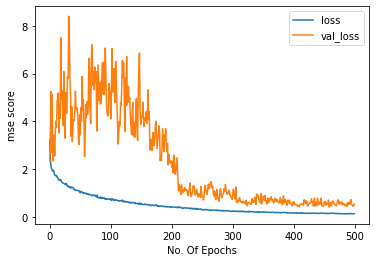

In [4]:
opt = optimizers.Adam(lr=0.0009)
print('Train...')
model.compile(optimizer = opt , loss="mse")
#model.compile(optimizer = "adam" , loss="mse")
history = model.fit([x_train,x_train], y_train, epochs = 500, batch_size=24, validation_split=0.1, shuffle=True)
# history = model.fit(x_train, y_train, epochs = 500, batch_size=6, validation_split=0.1, shuffle=True)
model.summary()
#Save Model
model.save('GRU_Single_Attention_model_alls.h5')  # creates a HDF5 file 
del model

custom_ob = {'LayerNormalization': LayerNormalization , 'SeqSelfAttention':SeqSelfAttention}
model = load_model('GRU_Single_Attention_model_alls.h5', custom_objects=custom_ob)
t1 = time.time()
y_pred2 = model.predict([x_test,x_test])
#y_pred2 = model.predict(x_test)
#y_pred = model.predict(x_train)
t2 = time.time()
print('Predict time: ',t2-t1)
y_pred = scaler.inverse_transform(y_pred2)#Undo scaling
rmse_lstm2 = np.sqrt(mean_squared_error(y_test, y_pred2))
#rmse_lstm = np.sqrt(mean_squared_error(y_train, y_pred))
#print('RMSE: ',rmse_lstm)
print('RMSE2: ',rmse_lstm2)
mae2 = mean_absolute_error(y_test, y_pred2)
#mae = mean_absolute_error(y_train, y_pred)
#print('MAE: ',mae)
print('MAE2: ',mae2)
r22 =  r2_score(y_test, y_pred2)
# r2 =  r2_score(y_train, y_pred)
# print('R-square: ',r2)
print('R-square2: ',r22)

# n = len(y_test)
# p = 12
# Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
# Adj_r22 = 1-(1-r22)*(n-1)/(n-p-1)
# print('Adj R-square: ',Adj_r2)
# print('Adj R-square2: ',Adj_r22)

plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [7]:
d = pd.read_csv("Mode2_bike_all.csv")
d.head()



,timestamp,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,"Great Marlborough Street, Soho(159)","Rathbone Street, Fitzrovia(306)","Frith Street, Soho","Green Street, Mayfair","Golden Square, Soho(129)","Craven Street, Strand(341)",cnt
0,2015/9/6 00:00,11.0,11.0,72.0,5.0,1,0,1,2,2,1,1,0,1,2,2
1,2015/9/6 01:00,10.0,10.0,82.0,6.0,1,0,1,2,1,1,12,0,2,2,7
2,2015/9/6 02:00,10.0,10.0,82.0,5.0,1,0,1,2,0,0,6,4,1,0,2
3,2015/9/6 03:00,10.0,10.0,79.0,6.0,1,0,1,2,2,0,3,0,0,0,1
4,2015/9/6 04:00,9.0,8.0,84.5,8.0,1,0,1,2,8,0,0,0,0,0,1
